In [25]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import seaborn as sns
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [26]:
table = read_csv('Quadranti.csv')
table.head()

,Unnamed: 0,Date,Ammonia,PM10,PM25,Wind_speed,Temperature,Rainfall,Quadrante
0,0,2014-01-01T00:00:00Z,0.0,6.0,7.0,0.443554,-0.334965,0.0,2
1,1,2014-01-02T00:00:00Z,0.0,6.0,5.0,0.355915,-0.486111,7.8,2
2,2,2014-01-03T00:00:00Z,0.0,11.0,4.0,0.207631,2.220588,0.0,2
3,3,2014-01-04T00:00:00Z,0.0,6.0,7.0,1.024926,2.137063,35.8,2
4,4,2014-01-05T00:00:00Z,0.0,3.0,8.0,0.666721,2.416084,25.0,2


In [27]:
#Moggio = table.loc[table.loc[:,"NameStation"]=="Moggio",:]
Moggio = table.loc[:,["Date","Ammonia","PM10","PM25","Wind_speed","Quadrante","Temperature","Rainfall"]]
Moggio = Moggio.dropna(how="any")
Moggio = Moggio.reset_index()
Moggio = Moggio.iloc[:-365,:] # we train not using 2020, for now
Moggio = Moggio[['index', 'Date', 'PM10', 'Ammonia',
               'PM25', 'Wind_speed', 'Temperature', 'Rainfall', 'Quadrante']]
Moggio.head()


,index,Date,PM10,Ammonia,PM25,Wind_speed,Temperature,Rainfall,Quadrante
0,0,2014-01-01T00:00:00Z,6.0,0.0,7.0,0.443554,-0.334965,0.0,2
1,1,2014-01-02T00:00:00Z,6.0,0.0,5.0,0.355915,-0.486111,7.8,2
2,2,2014-01-03T00:00:00Z,11.0,0.0,4.0,0.207631,2.220588,0.0,2
3,3,2014-01-04T00:00:00Z,6.0,0.0,7.0,1.024926,2.137063,35.8,2
4,4,2014-01-05T00:00:00Z,3.0,0.0,8.0,0.666721,2.416084,25.0,2


<AxesSubplot:xlabel='Date', ylabel='Ammonia'>

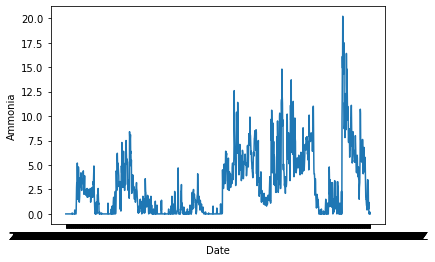

In [28]:
sns.lineplot(x='Date', y='Ammonia', data=Moggio)

##Convert series to supervised learning
### Activation function = tanh and logistic (s curve)

###Conversion Function

In [29]:
from pandas import DataFrame
from pandas import concat
 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

### Conversion of Moggio

In [30]:
values = Moggio.iloc[:,2:].values
# ensure all data is float
values = values.astype('float32') #cast in float 32 bit per evitare problemi
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
n_days = 5 #Memoria della NN
reframed = series_to_supervised(scaled, n_days, 1) # info of the past 5 days to determine next (1) day
# drop columns we don't want to predict (we therefore keep Ammonia)
reframed.drop(reframed.columns[[36,37,38,39,40,41]], axis=1, inplace=True)

reframed.head()

,var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var6(t-5),var7(t-5),var1(t-4),var2(t-4),var3(t-4),...,var6(t-2),var7(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t)
5,0.066667,0.0,0.088608,0.169316,0.286365,0.000000,0.333333,0.066667,0.0,0.063291,...,0.161552,0.333333,0.033333,0.0,0.101266,0.256247,0.358295,0.112816,0.333333,0.022222
6,0.066667,0.0,0.063291,0.135178,0.282413,0.035199,0.333333,0.122222,0.0,0.050633,...,0.112816,0.333333,0.022222,0.0,0.025316,0.078711,0.406390,0.000000,0.000000,0.077778
7,0.122222,0.0,0.050633,0.077417,0.353183,0.000000,0.333333,0.066667,0.0,0.088608,...,0.000000,0.000000,0.077778,0.0,0.088608,0.035589,0.397825,0.000000,0.000000,0.044444
8,0.066667,0.0,0.088608,0.395778,0.350999,0.161552,0.333333,0.033333,0.0,0.101266,...,0.000000,0.000000,0.044444,0.0,0.050633,0.208928,0.408315,0.000000,0.333333,0.044444
9,0.033333,0.0,0.101266,0.256247,0.358295,0.112816,0.333333,0.022222,0.0,0.025316,...,0.000000,0.333333,0.044444,0.0,0.088608,0.065975,0.392536,0.000000,0.000000,0.133333


In [31]:
# split into train and test sets
values = reframed.values
n_features = 7 # number of variables, including the one to be predicted
n_train_days = 1312 # we train using only the first few year
train = values[:n_train_days, :]
test = values[n_train_days:, :] # we test using all successive years 
# split into input and outputs
n_obs = n_days * n_features
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
# reshape from 2D to 3D
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1312, 35) 1312 (1312,)
(1312, 5, 7) (1312,) (350, 5, 7) (350,)


# Modeling and training

Epoch 1/500


2022-02-22 20:51:05.071016: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-22 20:51:05.218040: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-22 20:51:05.247953: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-22 20:51:05.275950: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-22 20:51:05.322081: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-22 20:51:05.374587: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-22 20:51:05.432302: I tensorflow/core/grappler/optimizers/cust

27/27 - 2s - loss: 0.1114 - val_loss: 0.0872


2022-02-22 20:51:06.204100: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-22 20:51:06.252381: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-22 20:51:06.280595: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-22 20:51:06.310108: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 2/500
27/27 - 0s - loss: 0.0912 - val_loss: 0.0868
Epoch 3/500
27/27 - 0s - loss: 0.0901 - val_loss: 0.0853
Epoch 4/500
27/27 - 0s - loss: 0.0894 - val_loss: 0.0850
Epoch 5/500
27/27 - 0s - loss: 0.0911 - val_loss: 0.0869
Epoch 6/500
27/27 - 0s - loss: 0.0943 - val_loss: 0.1022
Epoch 7/500
27/27 - 0s - loss: 0.1079 - val_loss: 0.0881
Epoch 8/500
27/27 - 0s - loss: 0.0963 - val_loss: 0.0876
Epoch 9/500
27/27 - 0s - loss: 0.0962 - val_loss: 0.0872
Epoch 10/500
27/27 - 0s - loss: 0.0958 - val_loss: 0.0872
Epoch 11/500
27/27 - 0s - loss: 0.0967 - val_loss: 0.0906
Epoch 12/500
27/27 - 0s - loss: 0.0945 - val_loss: 0.0876
Epoch 13/500
27/27 - 0s - loss: 0.0973 - val_loss: 0.0895
Epoch 14/500
27/27 - 0s - loss: 0.0954 - val_loss: 0.0877


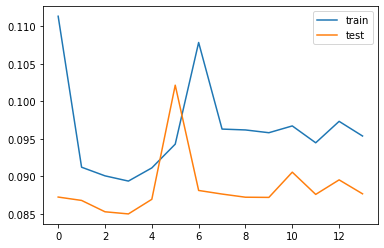

In [32]:
# design the neural network
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
early_stopping = EarlyStopping(patience=10, restore_best_weights = True)
history = model.fit(train_X, train_y, epochs=500, batch_size=50, validation_data=(test_X, test_y), verbose=2, shuffle=False, callbacks=early_stopping)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

## Predictions of the year 2019

In [33]:
# make a prediction
yhat = model.predict(test_X)
#Convert from 3D to 2D
test_X = test_X.reshape((test_X.shape[0], n_days*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

2022-02-22 20:51:12.357700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-22 20:51:12.401284: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-22 20:51:12.431435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-22 20:51:12.460541: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Test RMSE: 9.723


#### Prediciton plots

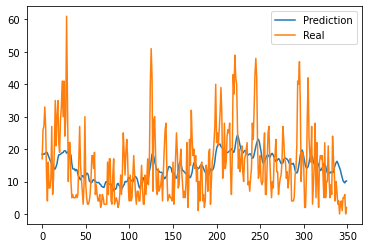

In [34]:
pyplot.plot(inv_yhat, label = 'Prediction')
pyplot.plot(inv_y, label = 'Real')
pyplot.legend()
pyplot.show()

# Modeling with hyperparamenter search
# Goal: reduce the MSE without overfitting

In [35]:
!pip install -q -U keras-tuner

In [36]:
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt #Keras Creates a better model

In [37]:
tf.config.list_physical_devices('GPU') #To undestand which GPU using during the training

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Function to create new models

In [38]:
def model_builder(hp):
  #design network
  #object created with keras_tuner -> iterates some parameters to create the model
  #units = neurons we use 32 steps for each time
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  #Initialization of the model
  model = Sequential() 
  model.add(LSTM(units = hp_units,return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
  #for loop to iterate different quantities of layer (from 1 to 3 layer)
  for i in range(hp.Int('layers',1,3)):
   model.add(LSTM(units = hp_units, return_sequences=True))
  model.add(LSTM(units = hp_units, return_sequences=False))
  model.add(Dense(1))
  #Choose from a list of given instructions -> we choose leanrning rates
  #We look the performances
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model.compile(loss='mae', optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate))
  return model

# Creation of the object with model_builder(hp)
## Parameter to look at: validation loss

In [39]:
tuner = kt.RandomSearch(
    model_builder,
    objective='val_loss',
    max_trials=10,
    executions_per_trial =3,
    directory = 'dir',
    project_name = 'namee')
tuner.search_space_summary()

INFO:tensorflow:Reloading Oracle from existing project dir/namee/oracle.json
Search space summary
Default search space size: 3
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [40]:
early_stopping = EarlyStopping(monitor='val_loss',patience=10)
tuner.search(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y),shuffle=False, callbacks=[early_stopping])


Search: Running Trial #2

Hyperparameter    |Value             |Best Value So Far 
units             |64                |?                 
layers            |2                 |?                 
learning_rate     |0.0001            |?                 

Epoch 1/100


2022-02-22 20:51:15.551439: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-22 20:51:15.739827: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-22 20:51:15.776402: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-22 20:51:15.810336: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-22 20:51:15.854804: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-22 20:51:15.909707: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 1/19 [>.............................] - ETA: 32s - loss: 0.1557

2022-02-22 20:51:15.996661: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-22 20:51:16.062753: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-22 20:51:16.119421: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - ETA: 0s - loss: 0.1738

ValueError: in user code:

    /Users/marcovinciguerra/miniforge3/lib/python3.9/site-packages/keras/engine/training.py:1330 test_function  *
        return step_function(self, iterator)
    /Users/marcovinciguerra/miniforge3/lib/python3.9/site-packages/keras/engine/training.py:1320 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/marcovinciguerra/miniforge3/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/marcovinciguerra/miniforge3/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/marcovinciguerra/miniforge3/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/marcovinciguerra/miniforge3/lib/python3.9/site-packages/keras/engine/training.py:1313 run_step  **
        outputs = model.test_step(data)
    /Users/marcovinciguerra/miniforge3/lib/python3.9/site-packages/keras/engine/training.py:1267 test_step
        y_pred = self(x, training=False)
    /Users/marcovinciguerra/miniforge3/lib/python3.9/site-packages/keras/engine/base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /Users/marcovinciguerra/miniforge3/lib/python3.9/site-packages/keras/engine/input_spec.py:214 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 35)


In [ ]:
tuner.results_summary()

Results summary
Results in dir/namee
Showing 10 best trials
Objective(name='val_loss', direction='min')


### Hyperband

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

INFO:tensorflow:Reloading Oracle from existing project my_dir/intro_to_kt/oracle.json
INFO:tensorflow:Reloading Tuner from my_dir/intro_to_kt/tuner0.json


In [ ]:
tuner.search(train_X, train_y, epochs=1000, batch_size=72, validation_data=(test_X, test_y),shuffle=False, callbacks=[early_stopping])